<img src="escuela-de-economia.png" width="260" height="60">
<center>
    <b>EC4301 MACROECONOMETRÍA</b><br>
    <b>Profesor:  Randall Romero Aguilar, PhD</b>
<br><br>
<b>Laboratorio:</b>
<div style="font-size:175%;color:white; background-color: #0064b0;">Tema 5: Modelos para series con tendencia</div>
<div style="font-size:250%;color:white; background-color: #0064b0;">Pruebas de raíz unitaria para el PIB en Costa Rica</div> 
</center>
<i>Creado:     2020-May-01 
    <br>
    Actualizado: 2020-Oct-07</i>

In [1]:
if 'google.colab' in str(get_ipython()):
    print("Este cuaderno está corriendo en Google Colab. Es necesario instalar el paquete bccr para obtener los datos")
    !pip install bccr
else:
    print("Este cuaderno está corriendo localmente.")

Este cuaderno está corriendo localmente.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [3]:
from statsmodels.tsa.stattools import adfuller, kpss

In [4]:
plt.style.use('seaborn')
plt.rc('figure', figsize=(15,4))
plt.rc('axes', titlesize=20, labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

# Obtener y graficar los datos del PIB

## Descargar los datos

In [5]:
import bccr

In [6]:
consulta = bccr.ServicioWeb()
#consulta.buscar(todos='Producto interno bruto encadenado')

In [7]:
pib = consulta({'33783':'PIB'})
pib['lPIB'] = np.log(pib['PIB'])

temp = pib.copy()
temp.index = pib.index.to_series().astype(str)
temp.reset_index().to_stata('pib-costa-rica.dta')
del temp

## Gráfico de la serie

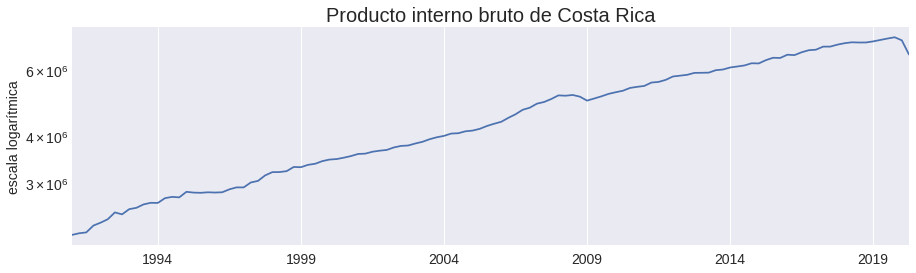

In [8]:
fig, ax = plt.subplots()
pib['PIB'].plot(ax=ax, legend=False)
ax.set(yscale='log', title='Producto interno bruto de Costa Rica', ylabel='escala logarítmica')
fig.savefig('pib-costa-rica-I(1).pdf', bbox_inches='tight')

## Correlograma del (logaritmo) del PIB y su primer diferencia

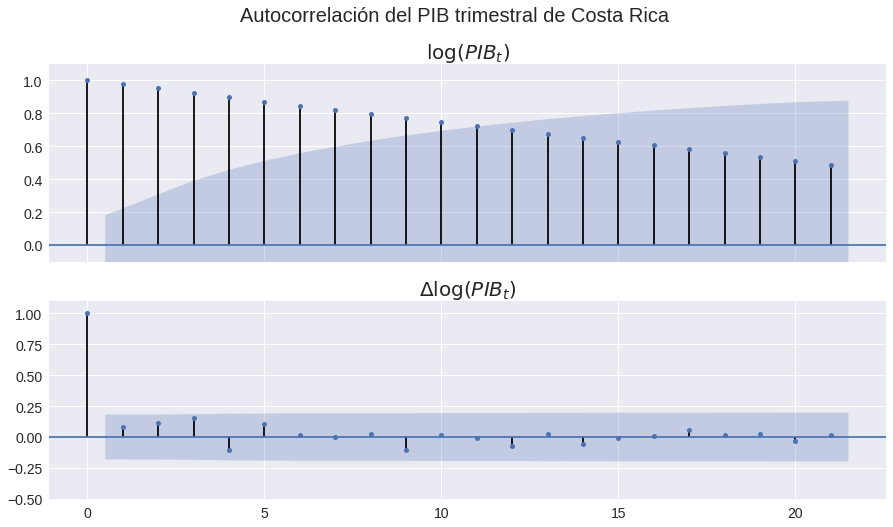

In [9]:
fig,axs = plt.subplots(2,1, figsize=[15,8], sharex=True)
sm.graphics.tsa.plot_acf(pib['lPIB'],ax=axs[0]);
axs[0].set(ylim=[-0.1,1.1], title='$\log(PIB_t)$')

sm.graphics.tsa.plot_acf(pib['lPIB'].diff().dropna(),ax=axs[1]);
axs[1].set(ylim=[-0.5,1.1], title='$\Delta\log(PIB_t)$')

fig.suptitle('Autocorrelación del PIB trimestral de Costa Rica', fontsize=20)
fig.savefig('pib-costa-rica-rho.pdf',bbox_inches='tight')

# Ajustando una tendencia lineal

## Estimando la tendencia y los residuos

In [10]:
pib['t'] = np.arange(pib.shape[0])

pib['tendencia'] = smf.ols('lPIB ~ t', pib).fit().fittedvalues
pib['residuos'] = pib['lPIB'] - pib['tendencia']

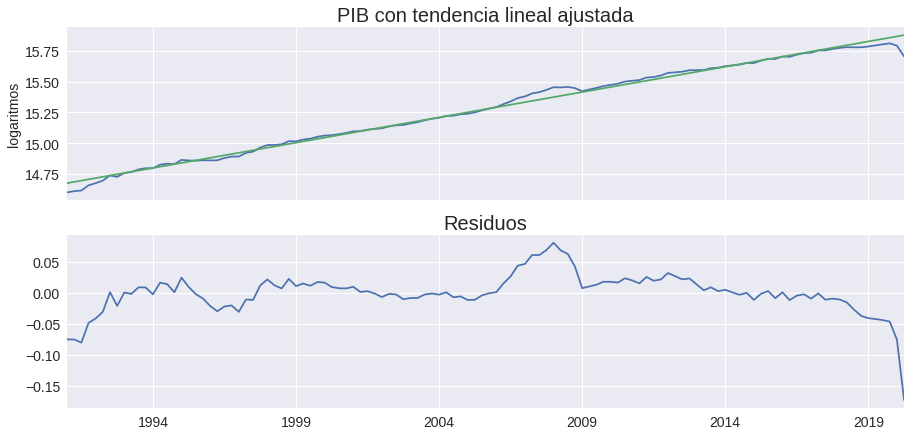

In [11]:
fig, axs = plt.subplots(2,1, figsize=[15,7], sharex=True)
pib[['lPIB','tendencia']].plot(ax=axs[0], legend=False)
axs[0].set(title='PIB con tendencia lineal ajustada', ylabel='logaritmos')

pib[['residuos']].plot(ax=axs[1], legend=False)
axs[1].set(title='Residuos')
fig.savefig('pib-tendencia-lineal.pdf', bbox_inches='tight')

## Correlograma de los residuos

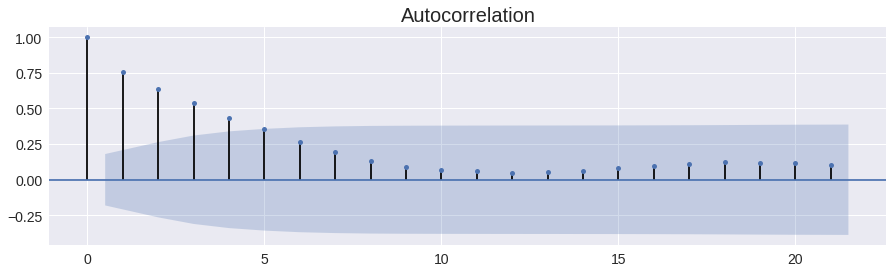

In [12]:
sm.graphics.tsa.plot_acf(pib['residuos']);

# Pruebas de DickeyFuller

## Implementando la prueba DF con regresión lineal

In [13]:
dy  = pib['lPIB'].diff()[1:]
ly = pib['lPIB'].shift(1)[1:]
tt = np.arange(dy.size)

X = sm.add_constant(ly)
Z = np.c_[X,tt]

In [14]:
tnc = sm.OLS(dy,ly, hasconst=False).fit().tvalues[0]
tc = sm.OLS(dy, X, hasconst=True).fit().tvalues[1]
tct = sm.OLS(dy, Z, hasconst=True).fit().tvalues[1]

In [15]:
tnc, tc, tct


(7.264019738940917, -2.9212106276680307, 0.5287937702080535)

In [16]:
tbl = sm.OLS(dy, X, hasconst=True).fit().summary().tables[1]

with open('df-lpib-regresion.tex','w') as cuadro:
    cuadro.write(tbl.as_latex_tabular())


## Implementando el código para hacer las tablas

In [17]:
specs = ['nc', 'c', 'ct']
indice = ['sin constante', 'con constante', 'con constante y tendencia']

def DF(datos, spec):
    res = adfuller(datos, maxlag=0,regression=spec)
    resultado = {
        'z':res[0], 
        '1%': res[4]['1%'], 
        '5%': res[4]['5%'], 
        '10%': res[4]['10%']}
    return resultado

def ADF(datos, spec):
    res = adfuller(datos, regression=spec, autolag='t-stat')
    resultado = {
        'z':res[0], 
        '1%': res[4]['1%'], 
        '5%': res[4]['5%'], 
        '10%': res[4]['10%'],
        'p': res[2]}
    return resultado

pruebas = {'df':DF, 'adf':ADF}

def tabla_dickey_fuller(serie, test, diff=0):
    datos = pib[serie].diff(diff) if diff else pib[serie]
    resultados = pd.DataFrame([pruebas[test](datos.dropna(), ss) for ss in specs], index=indice).round(3)
    nombre = '_'.join([test,serie,str(diff)])
    resultados.to_latex(nombre + '.tex')
    return resultados

## Prueba Dickey-Fuller

### Serie en nivel

In [18]:
tabla_dickey_fuller('lPIB','df')

,z,1%,5%,10%
sin constante,7.264,-2.585,-1.944,-1.615
con constante,-2.921,-3.488,-2.887,-2.580
con constante y tendencia,0.529,-4.038,-3.449,-3.149


### Serie en primer diferencia

In [19]:
tabla_dickey_fuller('lPIB', 'df', diff=1)

,z,1%,5%,10%
sin constante,-5.104,-2.585,-1.944,-1.615
con constante,-7.044,-3.488,-2.887,-2.580
con constante y tendencia,-7.687,-4.039,-3.449,-3.150


### Serie de los residuos alrededor de tendencia

In [20]:
tabla_dickey_fuller('residuos', 'df', diff=0)

,z,1%,5%,10%
sin constante,0.206,-2.585,-1.944,-1.615
con constante,0.240,-3.488,-2.887,-2.580
con constante y tendencia,0.529,-4.038,-3.449,-3.149


## Prueba aumentada de Dickey-Fuller

### Serie en nivel

In [21]:
tabla_dickey_fuller('lPIB', 'adf', diff=0)

,z,1%,5%,10%,p
sin constante,1.523,-2.586,-1.944,-1.615,4
con constante,-2.040,-3.490,-2.887,-2.581,4
con constante y tendencia,1.331,-4.045,-3.452,-3.151,9


### Serie en primer diferencia

In [22]:
tabla_dickey_fuller('lPIB', 'adf', diff=1)

,z,1%,5%,10%,p
sin constante,-1.746,-2.586,-1.944,-1.615,2
con constante,-2.387,-3.490,-2.887,-2.581,3
con constante y tendencia,-3.020,-4.041,-3.450,-3.150,3


### Serie de los residuos alrededor de tendencia

In [23]:
tabla_dickey_fuller('residuos', 'adf', diff=0)

,z,1%,5%,10%,p
sin constante,0.622,-2.586,-1.944,-1.615,4
con constante,0.794,-3.490,-2.887,-2.581,4
con constante y tendencia,1.331,-4.045,-3.452,-3.151,9


# Pruebas KPSS

In [24]:
def KPSS_una_serie(datos, tipo):
    return [kpss(datos.dropna(), regression=tipo, nlags=k)[0] for k in range(7)]   

In [25]:
critical = pd.DataFrame(
    {'c': np.array([0.347, 0.463, 0.574, 0.739]),
     'ct':np.array([0.119, 0.146, 0.176, 0.216])},
    index=['10%', '5%', '2.5%', '1%'])


In [26]:
def tabla_KPSS(diff=0):
    datos = pib['lPIB'].diff(diff) if diff else pib['lPIB']
    resultados = pd.DataFrame([KPSS_una_serie(datos, ss) for ss in ['c','ct']], index=['c','ct']).round(3)
    #nombre = '_'.join([test,serie,str(diff)])
    #resultados.to_latex(nombre + '.tex')
    return resultados.T

In [29]:
#%%capture
tab = pd.concat([tabla_KPSS(diff=r) for r in range(2)], axis=1,keys=['nivel','diferencia'])

/home/randall/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/randall/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/randall/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/randall/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/randall/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/

In [30]:
tab.to_latex('kpss_lPIB.tex')
tab

nivel        diferencia       
        c     ct          c     ct
0  11.769  1.214      0.773  0.127
1   5.953  0.691      0.715  0.123
2   4.008  0.499      0.653  0.115
3   3.035  0.399      0.589  0.106
4   2.451  0.339      0.574  0.106
5   2.062  0.299      0.550  0.103
6   1.784  0.271      0.532  0.101

In [31]:
critical.to_latex('kpss_critical.tex')